# Objetivo

  Realizar un modelado simple para predecir, dada una publicación, la cantidad de ítems vendidos.
  Para esto, se debe ejecutar primero el archivo Recolección_de_datos.ipynb, el cual genera el dataset con la información que posteriormente será utilizada.
  La información con la que se trabajará se recolectó del sitio de MercadoLibre Argentina y solo se consideró la categoría de "Cámaras y Accesorios, de la cual se recolectaron aproximadamente 1000 publicaciones por cada subcategoría presente.

# Importaciones

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%cd "drive/MyDrive/DataScienceChallengeMELI/Modelado"

/content/drive/MyDrive/DataScienceChallengeMELI/Modelado


In [5]:
!pip install import_ipynb

In [6]:
import numpy as np

import pandas as pd
pd.set_option('display.max_columns', 22) # Show all columns when looking at dataframe
pd.set_option('display.max_rows', 100) # Show all rows when looking at dataframe
pd.set_option('display.max_colwidth', 1000)

import matplotlib.pyplot as plt
import matplotlib as mlp
mlp.rcParams['figure.figsize'] = 12,8
import seaborn as sns 
sns.set_style('dark')


import import_ipynb
from funciones_aux import request_a_diccionario, devuelve_tipo_dato, cantidad_nulos

importing Jupyter notebook from funciones_aux.ipynb


# Recolección de datos

Para la recolección y análisis de datos, se tiene en cuenta el sitio de MercadoLibre correspondiente a Argentina y la categoría "Cámaras y accesorios.

Se determinan las subcategorías englobadas dentro de la categoría principal seleccionada.

In [ ]:
categorias_all = request_a_diccionario("https://api.mercadolibre.com/sites/MLA/categories/all")

In [ ]:
lista_subcategorias_id = []
lista_subcategorias_name = []
lista_subcategorias_cant_items = []

for categoria_id in list(categorias_all.keys()):
    dicc_info_particular = categorias_all[categoria_id]
    categoria_name = dicc_info_particular["name"]
    cant_items_totales = dicc_info_particular["total_items_in_this_category"]
    lista_categorias_padre = dicc_info_particular['path_from_root']
    categoria_principal_id = lista_categorias_padre[0]["id"]
    if categoria_principal_id == "MLA1039" and len(lista_categorias_padre) > 1:
        lista_subcategorias_id.append(categoria_id)
        lista_subcategorias_name.append(categoria_name)
        lista_subcategorias_cant_items.append(cant_items_totales)

df_info_subcategorias = pd.DataFrame({"id": lista_subcategorias_id, "nombre":lista_subcategorias_name, 
              "cant_items":lista_subcategorias_cant_items})

In [ ]:
df_info_subcategorias.sort_values("cant_items", ascending = False)

,id,nombre,cant_items
5,MLA1049,Accesorios para Cámaras,33080
2,MLA430361,Cámaras,21165
28,MLA1042,Cámaras Digitales,14817
9,MLA59376,Lentes y Filtros,12390
59,MLA412430,Soportes y Estabilizadores,9378
...,...,...,...
116,MLA430416,Protectores de Hélices,0
115,MLA430415,Motores,0
114,MLA430414,Módulos,0
113,MLA430413,Mochilas y Estuches,0


In [ ]:
print("Hay un total de", len(df_info_subcategorias), "subcategorías de la categoría 'Cámaras y accesorios'.")

Hay un total de 136 subcategorías de la categoría 'Cámaras y accesorios'.


Se trabajará con un dataset que contiene aproximadamente 1000 publicaciones por cada una de las subcategorías anteriores.

In [ ]:
df_total = pd.read_csv("df_total_original.csv")

In [ ]:
print("Cantidad total de productos:",df_total.shape[0])
print("Cantidad total de información perteneciente a cada producto:", df_total.shape[1])

Cantidad total de productos: 49004
Cantidad total de información perteneciente a cada producto: 21


In [ ]:
df_total.head(2)

,id,site_id,title,price,currency_id,available_quantity,sold_quantity,buying_mode,listing_type_id,condition,accepts_mercadopago,address__state_name,address__city_name,shipping__free_shipping,shipping__store_pick_up,original_price,category_id,official_store_id,catalog_product_id,attributes__marca,attributes__modelo
0,MLA920562915,MLA,Portaretrato Cuadro Foto 20x30 Diploma Para Apoyar O Colgar,699.0,ARS,200.0,500.0,buy_it_now,gold_special,new,1.0,Buenos Aires,Banfield,0.0,0.0,NaN,MLA1634,NaN,NaN,VGO,BDA
1,MLA658120027,MLA,Portarretrato Digital Pulgadas Control Remoto Porta Retrato,15999.0,ARS,1.0,500.0,buy_it_now,gold_special,new,1.0,Capital Federal,Almagro,1.0,0.0,NaN,MLA73567,NaN,NaN,Daza,DZDPF8001


Se seleccionarán las variables que se consideran importantes.

In [ ]:
variables_seleccionadas = ['title', 'price', 'available_quantity', 'sold_quantity', 'buying_mode',
                           'condition', 'accepts_mercadopago', 'address__state_name',
                           'shipping__free_shipping', 'shipping__store_pick_up',
                           'original_price', 'category_id', 'attributes__marca', 'attributes__modelo']

In [ ]:
df_total = df_total[variables_seleccionadas]
df_total.head(2)

,title,price,available_quantity,sold_quantity,buying_mode,condition,accepts_mercadopago,address__state_name,shipping__free_shipping,shipping__store_pick_up,original_price,category_id,attributes__marca,attributes__modelo
0,Portaretrato Cuadro Foto 20x30 Diploma Para Apoyar O Colgar,699.0,200.0,500.0,buy_it_now,new,1.0,Buenos Aires,0.0,0.0,NaN,MLA1634,VGO,BDA
1,Portarretrato Digital Pulgadas Control Remoto Porta Retrato,15999.0,1.0,500.0,buy_it_now,new,1.0,Capital Federal,1.0,0.0,NaN,MLA73567,Daza,DZDPF8001


# Análisis y procesamiento de variables

Variable| Tipo |
---|---|
title| categórica
price| numérica
available_quantity| categórica
sold_quantity| categórica
buying_mode| categórica
condition| categórica
accepts_mercapago| categórica
address__state_name| categórica
shipping__free_shipping| categórica
shipping__stores_pick_up| categórica
original_price| numérica
category_id| categórica
attributes__marca| categórica
attributes__modelo| categórica

Para cada una de las variables seleccionadas, se realizará:


*   Descripción de la variable
*   Tipo de dato (entero, flotante, booleano, otros)
*   Análisis de valores nulos
*   Distribución de la variable






## Variable: title

In [ ]:
variable = 'title'

### Descripción

Se trata de una variable categórica que representa el título de la publicación.

### Tipo de dato

In [ ]:
devuelve_tipo_dato(df_total[variable], variable)

La variable title es un dato objeto.


### Análisis de valores nulos

In [ ]:
cantidad_nulos(df_total[variable], variable)

La variable title tiene 0 datos nulos registrados que representan el 0.0 % del total de datos.


### Distribución

In [ ]:
print('Porcentaje de distribución para la variable title:')
(df_total['title'].value_counts(normalize = True).sort_values(ascending = False)) * 100

Porcentaje de distribución para la variable title:


Cubiertas Camara Web Multiuso, Negro/deslizantes/protectora     0.040813
Aro De Luz Led 16cm Profesional Foto Video 3 Luces + Tripode    0.034691
Adaptador De Tripode Y Monopod Celulares Soporte Smartphone     0.026528
Ezviz C3a Soporte Original Reforzado Angulo Ajustable -5%       0.024488
Parasol Pétalo 72mm Para Camara Nikon Canon Olympus Sony        0.022447
                                                                  ...   
Bowens Gemini 750w Studio Flash Flashes Profoto Prometh         0.002041
Flash De Estudio Blazzeo Swift 250                              0.002041
Flash De Estudio Blazzeo Swift 180a Impecable                   0.002041
Kit 3 Flashes Estudio Blazzeo: 2 Swift 250a + 1 Swift 180a      0.002041
Manija Con Enganche A Rosca Para Camara De Fotos O Filmadora    0.002041
Name: title, Length: 44584, dtype: float64

## Variable: price

In [ ]:
variable = 'price'

### Descripción

Se trata de una variable numérica, en donde si la pubicación presenta descuento este valor es el precio con descuento de la misma, mientras que si la publicación no tiene descuento, este campo es el precio de la publicación.

### Tipo de dato

In [ ]:
devuelve_tipo_dato(df_total[variable], variable)

La variable price es un dato flotante.


### Análisis de valores nulos

In [ ]:
cantidad_nulos(df_total[variable], variable)

La variable price tiene 0 datos nulos registrados que representan el 0.0 % del total de datos.


### Distribución

Información de la distribución de precios para productos con y sin descuento.

In [ ]:
df_total[variable].describe()

count    4.900400e+04
mean     3.861822e+04
std      2.525270e+06
min      7.000000e+01
25%      1.572342e+03
50%      4.999000e+03
75%      1.600000e+04
max      5.555556e+08
Name: price, dtype: float64

Se puede observar que hay muchisima diferencia de precios.

Se determina cuál es la publicación que presenta el precio máximo.

In [ ]:
df_total.groupby( by= 'title')['price'].max().sort_values(ascending = False)

title
Cámara Multiespectral Agrodat Geo 3 - Ndvi                      555555555.0
Microscopio Hasta 1200x Exploration - Con Luz - Bunny Toys       49262289.0
Nikon Accesorio De Control De Apertura Ds-12                     27000000.0
Drone Aeroplano A Escala,hyper Junk Profesional.                  9524000.0
Drone Vtol Alcance 150 Km                                         7450000.0
                                                                   ...     
Tapa Caja Super 8 Blanca Nieves Y Los Siete Enanos Disney              99.0
Restauracion Digital De Fotos Dañadas Colorizacion Impresa             99.0
Retoque Digital Fotográfico. Edición Y Restauración.                   99.0
Canon Eos Rebel Xti Lente Ef35-80mm Bolso 2cards A Voluntad!           99.0
Display M2520 Y 2510  Samsung +  De Regalo Otros Respuestos!           80.0
Name: price, Length: 44584, dtype: float64

Se visualiza mejor los valores que están fuera de rango.

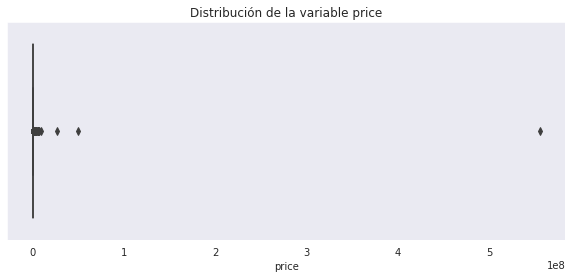

In [ ]:
plt.figure(figsize = (10, 4))
ax = plt.axes()
ax = sns.boxplot(x=df_total.price)
ax.set_title("Distribución de la variable price")
plt.show()

Analizando los datos anteriores, se buscó en la página de MercadoLibre el producto: "Cámara Multiespectral Agrodat Geo 3 - Ndvi", correspondiente al precio máximo que figura en el dataset, observándose que el mismo no es real ya que, en la descripción del producto el vendedor publica el precio para el mes de abril del corriente año a $187.500. Se decide eliminar los 3 ítems con el mayor precio ya que, por su descripción el precio no tiene sentido. Los precios seguirán teniendo una gran variación ya que, en esta categoría tenemos accesorios como estuches para cámaras, asi como también drones profesionales.

In [ ]:
df_total = df_total.drop(df_total[df_total['price'] > 10000000.0].index)

## Variable: available_quantity

In [ ]:
variable = 'available_quantity'

### Descripción

Se trata de una variable categórica que representa la cantidad disponible de ejemplares de un determinado producto.

### Tipo de dato

In [ ]:
devuelve_tipo_dato(df_total[variable], variable)

La variable available_quantity es un dato flotante.


Se transformará el tipo de dato a entero.

In [ ]:
df_total['available_quantity'] = df_total['available_quantity'].astype('int64')

### Análisis de valores nulos

In [ ]:
cantidad_nulos(df_total[variable], variable)

La variable available_quantity tiene 0 datos nulos registrados que representan el 0.0 % del total de datos.


### Distribución

Recuento de las publicaciones para determinadas cantidades de disponibilidad de ejemplares, expresado en porcentaje, en donde la primera columna corresponde a la disponibilidad. Se tienen en cuenta rangos de disponibilidad.

In [ ]:
round(((df_total[variable].value_counts(normalize = True))*100).head(9).sort_index(), 3)

1        84.102
50        5.841
100       3.531
150       1.320
200       0.249
250       1.080
500       2.343
5000      0.869
50000     0.153
Name: available_quantity, dtype: float64

Recuento de las publicaciones para determinadas cantidades de disponibilidad de ejemplares, en donde la primera columna corresponde a la disponibilidad. Se tienen en cuenta rangos de disponibilidad.

In [ ]:
df_total[variable].value_counts().head(10).sort_index()

1        41211
2           35
50        2862
100       1730
150        647
200        122
250        529
500       1148
5000       426
50000       75
Name: available_quantity, dtype: int64

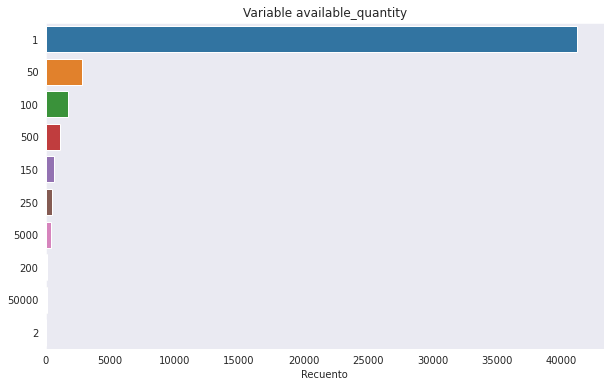

In [ ]:
plt.figure(figsize = (10, 6))
plt.title('Variable available_quantity')
sns.countplot(y = df_total[variable], order = (df_total[variable].value_counts().head(10)).index)
plt.xlabel("Recuento", fontsize = 10)
plt.ylabel("")
plt.show()


## Variable: sold_quantity

In [ ]:
variable = 'sold_quantity'

### Descripción

Se trata de una variable categórica que representa la cantidad de ejemplares vendidos de una determinada publicación.

### Tipo de dato

In [ ]:
devuelve_tipo_dato(df_total[variable], variable)

La variable sold_quantity es un dato flotante.


Se transformará el tipo de dato a entero.

In [ ]:
df_total[variable] = df_total[variable].astype('int64')

### Análisis de valores nulos

In [ ]:
cantidad_nulos(df_total[variable], variable)

La variable sold_quantity tiene 0 datos nulos registrados que representan el 0.0 % del total de datos.


### Distribución

Recuento de las publicaciones para determinada cantidad de ejemplares vendidos, expresado en porcentaje, en donde la primera columna corresponde a la venta histórica. Se tienen en cuenta rangos de ventas.

In [ ]:
round(((df_total[variable].value_counts(normalize = True))*100).head(10).sort_index(), 3)

0      56.291
1       8.169
2       4.357
3       3.022
4       2.182
5      13.957
25      4.135
50      2.908
100     1.396
250     1.059
Name: sold_quantity, dtype: float64

Recuento de las publicaciones para determinada cantidad de ejemplares vendidos, en donde la primera columna corresponde a la venta histórica. Se tienen en cuenta rangos de ventas.

In [ ]:
df_total[variable].value_counts().head(10).sort_index()

0      27583
1       4003
2       2135
3       1481
4       1069
5       6839
25      2026
50      1425
100      684
250      519
Name: sold_quantity, dtype: int64

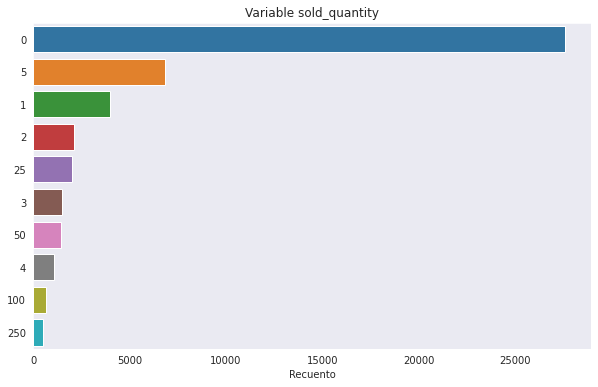

In [ ]:
plt.figure(figsize = (10, 6))
plt.title('Variable sold_quantity')
sns.countplot(y = df_total[variable], order = (df_total[variable].value_counts().head(10)).index)
plt.xlabel("Recuento", fontsize = 10)
plt.ylabel("")
plt.show()

## Variable: buying_mode

In [ ]:
variable = 'buying_mode'

### Descripción

Se trata de una variable categórica que representa el modo en que puede comprarse un determinado producto.

### Tipo de dato

In [ ]:
devuelve_tipo_dato(df_total[variable], variable)

La variable buying_mode es un dato objeto.


### Análisis de valores nulos

In [ ]:
cantidad_nulos(df_total[variable], variable)

La variable buying_mode tiene 0 datos nulos registrados que representan el 0.0 % del total de datos.


### Distribución

Recuento de las publicaciones para los distintos modos de compra que admite la plataforma expresado en porcentaje.

In [ ]:
round(((df_total[variable].value_counts(normalize = True))*100), 3)

buy_it_now    100.0
Name: buying_mode, dtype: float64

## Variable: condition

In [ ]:
variable = 'condition'

### Descripción

Se trata de una variable categórica que indica el estado de uso del ítem en cuestión.

### Tipo de dato

In [ ]:
devuelve_tipo_dato(df_total[variable], variable)

La variable condition es un dato objeto.


### Análisis de valores nulos

In [ ]:
cantidad_nulos(df_total[variable], variable)

La variable condition tiene 0 datos nulos registrados que representan el 0.0 % del total de datos.


### Distribución

Recuento de las publicaciones correspondientes a los distintos estados de uso presentes en el dataset, expresado en porcentaje.

In [ ]:
round(((df_total[variable].value_counts(normalize = True, dropna = False))*100).sort_index(), 3)

new              76.680
not_specified     0.084
used             23.236
Name: condition, dtype: float64

Recuento de las publicaciones correspondientes a los distintos estados de uso presentes en el dataset.

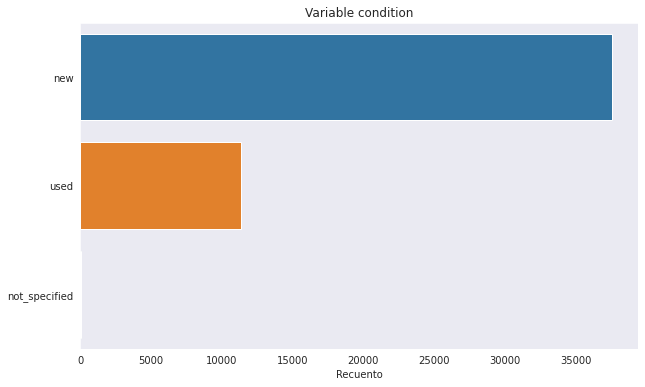

In [ ]:
plt.figure(figsize = (10, 6))
plt.title('Variable condition')
sns.countplot(y = df_total[variable], order = (df_total[variable].value_counts(dropna = False)).index)
plt.xlabel("Recuento", fontsize = 10)
plt.ylabel("")
plt.show()

## Variable: accepts_mercadopago

In [ ]:
variable = 'accepts_mercadopago'

### Descripción

Se trata de una variable categórica que indica si la publicación acepta o no mercadopago, para lo cual los valores que admite son: 1 si acepta, 0 si no acepta.

### Tipo de dato

In [ ]:
devuelve_tipo_dato(df_total[variable], variable)

La variable accepts_mercadopago es un dato flotante.


Se transformarán los valores correspondientes a un tipo de dato entero.

In [ ]:
df_total[variable] = df_total[variable].astype('int64')

### Análisis de valores nulos

In [ ]:
cantidad_nulos(df_total[variable], variable)

La variable accepts_mercadopago tiene 0 datos nulos registrados que representan el 0.0 % del total de datos.


### Distribución

Recuento de las publicaciones que aceptan o no mercadopago, expresado en porcentaje.

In [ ]:
round(((df_total[variable].value_counts(normalize = True, dropna = False))*100), 3)

1    100.0
Name: accepts_mercadopago, dtype: float64

## Variable: address__state_name

In [ ]:
variable = 'address__state_name'

### Descripción

Se trata de una variable categórica que representa la zona de la publicación.

### Tipo de dato

In [ ]:
devuelve_tipo_dato(df_total[variable], variable)

La variable address__state_name es un dato objeto.


### Análisis de valores nulos

In [ ]:
cantidad_nulos(df_total[variable], variable)

La variable address__state_name tiene 0 datos nulos registrados que representan el 0.0 % del total de datos.


### Distribución

Recuento de las publicaciones por zona, expresado en porcentaje.

In [ ]:
round(((df_total[variable].value_counts(normalize = True))*100), 3)

Capital Federal        62.419
Buenos Aires           28.601
Córdoba                 2.624
Santa Fe                2.453
Mendoza                 0.755
Santa Cruz              0.633
Entre Ríos              0.429
Río Negro               0.294
Chubut                  0.216
Neuquén                 0.212
Tucumán                 0.210
Misiones                0.190
Salta                   0.186
San Luis                0.129
Corrientes              0.118
Catamarca               0.110
San Juan                0.090
Jujuy                   0.067
La Pampa                0.061
Chaco                   0.061
La Rioja                0.057
Santiago del Estero     0.051
Formosa                 0.024
Tierra del Fuego        0.008
Name: address__state_name, dtype: float64

Recuento de las publicaciones por zona.

In [ ]:
df_total[variable].value_counts()

Capital Federal        30586
Buenos Aires           14015
Córdoba                 1286
Santa Fe                1202
Mendoza                  370
Santa Cruz               310
Entre Ríos               210
Río Negro                144
Chubut                   106
Neuquén                  104
Tucumán                  103
Misiones                  93
Salta                     91
San Luis                  63
Corrientes                58
Catamarca                 54
San Juan                  44
Jujuy                     33
La Pampa                  30
Chaco                     30
La Rioja                  28
Santiago del Estero       25
Formosa                   12
Tierra del Fuego           4
Name: address__state_name, dtype: int64

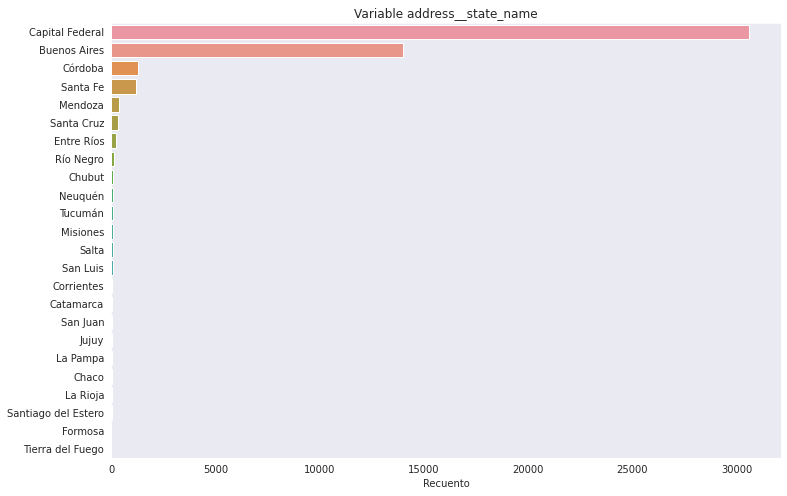

In [ ]:
plt.title('Variable address__state_name')
sns.countplot(y = df_total[variable], order = (df_total[variable].value_counts()).index)
plt.xlabel("Recuento", fontsize = 10)
plt.ylabel("")
plt.show()

## Variable: shipping__free_shipping

In [ ]:
variable = 'shipping__free_shipping'

### Descripción

Se trata de una variable categórica que indica si el envío del producto es o no gratuito, tomando valores de 1 si es gratuito y 0, en caso contrario.

### Tipo de dato

In [ ]:
devuelve_tipo_dato(df_total[variable], variable)

La variable shipping__free_shipping es un dato flotante.


Se transformará los valores correspondientes a un tipo de dato entero.

In [ ]:
df_total[variable] = df_total[variable].astype('int64')

### Análisis de valores nulos

In [ ]:
cantidad_nulos(df_total[variable], variable)

La variable shipping__free_shipping tiene 0 datos nulos registrados que representan el 0.0 % del total de datos.


### Distribución

Recuento de las publicaciones que presentan y no el envío gratis, expresado en porcentaje.

In [ ]:
round(((df_total[variable].value_counts(normalize = True))*100), 3)

0    56.721
1    43.279
Name: shipping__free_shipping, dtype: float64

Recuento de los productos que aceptan y no el envío gratis.

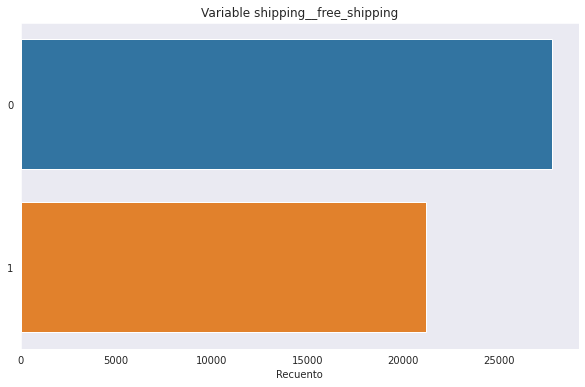

In [ ]:
plt.figure(figsize = (10, 6))
plt.title('Variable shipping__free_shipping')
sns.countplot(y = df_total[variable], order = (df_total[variable].value_counts()).index)
plt.xlabel("Recuento", fontsize = 10)
plt.ylabel("")
plt.show()

## Variable: shipping__store_pick_up

In [ ]:
variable = 'shipping__store_pick_up'

### Descripción

Se trata de una variable categórica que indica si el producto se retira o no en el local, tomando valores de True, si se retira por local o False para el caso contrario.

### Tipo de dato

In [ ]:
devuelve_tipo_dato(df_total[variable], variable)

La variable shipping__store_pick_up es un dato flotante.


Se transformarán los valores de la variable a un tipo de dato entero.

In [ ]:
df_total[variable] = df_total[variable].astype('int64')

### Análisis de valores nulos

In [ ]:
cantidad_nulos(df_total[variable], variable)

La variable shipping__store_pick_up tiene 0 datos nulos registrados que representan el 0.0 % del total de datos.


### Distribución

Recuento de las publicaciones que se retiran en el local y los que no, expresado en porcentaje.

In [ ]:
round(((df_total[variable].value_counts(normalize = True))*100), 3)

0    99.718
1     0.282
Name: shipping__store_pick_up, dtype: float64

Visto esto, se genera la pregunta de por qué es casi nula la cantidad de publicaciones que aceptan el retiro por local para esta categoría de cámaras y accesorios.

## Variable: original_price

In [ ]:
variable = 'original_price'

### Descripción

Se trata de una variable numérica que representa si un producto tiene o no descuento. Si este campo no es nulo, este valor representa el precio sin descuento. En cambio, si este campo es nulo, el producto no tiene descuento.

### Tipo de dato

In [ ]:
devuelve_tipo_dato(df_total[variable], variable)

La variable original_price es un dato flotante.


### Análisis de valores nulos

In [ ]:
cantidad_nulos(df_total[variable], variable)

La variable original_price tiene 47937 datos nulos registrados que representan el 97.83 % del total de datos.


### Distribución

Información estadística de los productos con descuento.

In [ ]:
df_total[variable].describe()

count      1064.000000
mean      27030.835216
std       79362.168873
min         144.000000
25%        2399.000000
50%        5989.500000
75%       13999.000000
max      883099.000000
Name: original_price, dtype: float64

Se puede observar que hay una gran diferencia de precios entre los productos ya que, en esta categoría se pueden encontrar desde accesorios como estuches hasta drones profesionales.

## Variable category_id

In [ ]:
variable = 'category_id'

### Descripción

Se trata de una variable categórica que representa el identificador de la subcategoría.

### Tipo de dato

In [ ]:
devuelve_tipo_dato(df_total[variable], variable)

La variable category_id es un dato objeto.


### Análisis de valores nulos

In [ ]:
cantidad_nulos(df_total[variable], variable)

La variable category_id tiene 0 datos nulos registrados que representan el 0.0 % del total de datos.


### Distribución

In [ ]:
round(((df_total[variable].value_counts(normalize = True))*100), 3)

MLA38267     2.045
MLA5649      2.043
MLA2893      2.043
MLA412431    2.043
MLA38186     2.043
             ...  
MLA430411    0.004
MLA430415    0.004
MLA430407    0.002
MLA430408    0.002
MLA430412    0.002
Name: category_id, Length: 130, dtype: float64

## Variable: attributes__marca

In [ ]:
variable = 'attributes__marca'

### Descripción

Se trata de una variable categórica que representa la marca del ítem publicado.

### Tipo de dato

In [ ]:
devuelve_tipo_dato(df_total[variable], variable)

La variable attributes__marca es un dato objeto.


### Análisis de valores nulos

In [ ]:
cantidad_nulos(df_total[variable], variable)

La variable attributes__marca tiene 4731 datos nulos registrados que representan el 9.65 % del total de datos.


Se reemplazan los valores nulos por "sin_marca".

In [ ]:
df_total['attributes__marca'] = df_total['attributes__marca'].fillna('sin_marca')

### Distribución

Recuento de las publicaciones pertenecientes a las distintas marcas disponibles, expresado en porcentaje.

In [ ]:
round(((df_total[variable].value_counts(normalize = True))*100), 3)

sin_marca                 9.655
DJI                       3.096
Canon                     2.492
Nikon                     2.480
Sony                      2.018
                          ...  
avenger                   0.002
LAGUER                    0.002
Tómbola taller gráfico    0.002
duque 200                 0.002
NewDoar                   0.002
Name: attributes__marca, Length: 6834, dtype: float64

## Variable: attributes__modelo

In [ ]:
variable = 'attributes__modelo'

### Descripción

Se trata de una variable categórica que representa el modelo del ítem publicado.

### Tipo de dato

In [ ]:
devuelve_tipo_dato(df_total[variable], variable)

La variable attributes__modelo es un dato objeto.


### Análisis de valores nulos

In [ ]:
cantidad_nulos(df_total[variable], variable)

La variable attributes__modelo tiene 7596 datos nulos registrados que representan el 15.5 % del total de datos.


Se reemplazan los valores nulos por "sin modelo".

In [ ]:
df_total['attributes__modelo'] = df_total['attributes__modelo'].fillna('sin_modelo')

### Distribución

Recuento de las publicaciones pertenecientes a los distintos modelos disponibles, expresado en porcentaje.

In [ ]:
round(((df_total[variable].value_counts(normalize = True))*100), 3)

sin_modelo             15.502
eg-cp14a                1.586
UC-E6                   0.720
ifc-300 ifc-400         0.392
HYDROGEL                0.302
                        ...  
Xdrone 107              0.002
Drone Syma X5hw         0.002
Koome K 300             0.002
Shell                   0.002
Universal Lens Case     0.002
Name: attributes__modelo, Length: 23015, dtype: float64

# Creación de variables

## Variable: tiene_descuento

Se generará la variable tiene_descuento en donde los valores que tomará serán 1, si la publicación tiene descuento o, 0, si no tiene descuento.

In [ ]:
df_total["tiene_descuento"] = df_total["original_price"].notna()
df_total = df_total.astype({"tiene_descuento": "int"})

## Variable: precio_sin_dcto

Se generará la variable precio_sin_dcto en donde si el ítem presenta descuento, dicha variable será el precio sin descuento del ítem, mientras que si el ítem no presenta descuento, el valor de la misma será el precio del ítem.

In [ ]:
conditions = [
               df_total['tiene_descuento'] == 0,
               df_total['tiene_descuento'] == 1 
             ]

outputs = [df_total['price'], df_total['original_price']]

In [ ]:
df_total['precio_sin_dcto'] = pd.Series(np.select(conditions, outputs))


## Variable: precio_con_dcto

Se generará la variable precio_con_dcto en donde si el ítem tiene descuento, el valor que tomará es el prcio con descuentos mientras que si el ítem no tiene descuento, el valor será el precio del ítem.

In [ ]:
conditions = [
               df_total['tiene_descuento'] == 0,
               df_total['tiene_descuento'] == 1 
             ]

outputs = [df_total['price'], df_total['price']]

In [ ]:
df_total['precio_con_dcto'] = pd.Series(np.select(conditions, outputs))


In [ ]:
df_total.head(2)

,title,price,available_quantity,sold_quantity,buying_mode,condition,accepts_mercadopago,address__state_name,shipping__free_shipping,shipping__store_pick_up,original_price,category_id,attributes__marca,attributes__modelo,tiene_descuento,precio_sin_dcto,precio_con_dcto
0,Portaretrato Cuadro Foto 20x30 Diploma Para Apoyar O Colgar,699.0,200,500,buy_it_now,new,1,Buenos Aires,0,0,NaN,MLA1634,VGO,BDA,0,699.0,699.0
1,Portarretrato Digital Pulgadas Control Remoto Porta Retrato,15999.0,1,500,buy_it_now,new,1,Capital Federal,1,0,NaN,MLA73567,Daza,DZDPF8001,0,15999.0,15999.0


## Variable: dcto_porcentual

Para calcular el descuento porcentual de un ítem se utilizará la siguiente fórmula:

***descuento porcentual = ((precio sin descuento - precio con descuento)/precio sin descuento) x100***


In [ ]:
conditions = [
               df_total['tiene_descuento'] == 0,
               df_total['tiene_descuento'] == 1 
             ]

outputs = [0, ((df_total['precio_sin_dcto'] - df_total['precio_con_dcto']) / df_total['precio_sin_dcto']) * 100]

In [ ]:
df_total['dcto_porcentual'] = pd.Series(np.select(conditions, outputs))


## Variable: stock

Para generar la variable stock se tuvo en cuenta los rangos que se presentaron al analizar la variable available_quantity.

In [ ]:
conditions = [
               df_total['available_quantity'] == 1,
               (df_total['available_quantity'] > 1) & (df_total['available_quantity'] <= 50), 
               (df_total['available_quantity'] > 50) & (df_total['available_quantity'] <= 100),
               (df_total['available_quantity'] > 100) & (df_total['available_quantity'] <= 150),
               (df_total['available_quantity'] > 150) & (df_total['available_quantity'] <= 200),
               (df_total['available_quantity'] > 200) & (df_total['available_quantity'] <= 250),
               (df_total['available_quantity'] > 250) & (df_total['available_quantity'] <= 500),
               (df_total['available_quantity'] > 500) & (df_total['available_quantity'] <= 5000),
               (df_total['available_quantity'] > 5000) & (df_total['available_quantity'] <= 50000)
             ]

outputs = [0, 1, 2, 3, 4, 5, 6, 7, 8]

In [ ]:
df_total['stock'] = pd.Series(np.select(conditions, outputs))


In [ ]:
(df_total["stock"].value_counts(normalize = True, ascending = False, dropna = False) * 100).sort_index()

0.0    84.098284
1.0     6.279464
2.0     3.559111
3.0     1.334667
4.0     0.253056
5.0     1.083651
6.0     2.359136
7.0     0.871411
8.0     0.155099
NaN     0.006122
Name: stock, dtype: float64

Se puede ver que un pequeño porcentaje de valores no caen dentro de los rangos generados, por lo que se procederá a determinar cuáles son esos valores.

In [ ]:
mask = df_total[df_total.stock.isna() == True]
mask

,title,price,available_quantity,sold_quantity,buying_mode,condition,accepts_mercadopago,address__state_name,shipping__free_shipping,shipping__store_pick_up,original_price,category_id,attributes__marca,attributes__modelo,tiene_descuento,precio_sin_dcto,precio_con_dcto,dcto_porcentual,stock
49001,"Estuches Para Lentes Antiguos Y Modernos, Origi Y Génericos",4000.0,1,0,buy_it_now,used,1,Capital Federal,0,0,NaN,MLA50090,Nikon. Canon. Pentax. Minolta. Olympus. Leica. Rolleiflex.,Varios.,0,NaN,NaN,NaN,NaN
49002,Estuche Marca P.angenieux Paris,1200.0,1,0,buy_it_now,used,1,Capital Federal,0,0,NaN,MLA50090,sin_marca,sin_modelo,0,NaN,NaN,NaN,NaN
49003,Manija Con Enganche A Rosca Para Camara De Fotos O Filmadora,1200.0,1,0,buy_it_now,used,1,Capital Federal,0,0,NaN,MLA50090,sin_marca,sin_modelo,0,NaN,NaN,NaN,NaN


Se puede ver que los datos que no caen dentro de ningún rango de stock son 3 y que se da cuando la variable available_quantity toma el valor de 1. Es un poco raro ya que, la codificación a 0 cuando dicha variable toma ese valor se generó correctamente para los registros restantes.

Se forzará la codificación a 0 para estos 3 registros.

In [ ]:
df_total.stock = df_total.stock.fillna(0)

In [ ]:
(df_total["stock"].value_counts(normalize = True, ascending = False, dropna = False) * 100).sort_index()

0.0    84.104406
1.0     6.279464
2.0     3.559111
3.0     1.334667
4.0     0.253056
5.0     1.083651
6.0     2.359136
7.0     0.871411
8.0     0.155099
Name: stock, dtype: float64

## Variable: cantidad_vendida

Para generar la variable cantidad_vendida, variable target, la cual se trata de una variable ordinal ya que, el volúmen de ventas tiene un orden de magnitud, se decide generar rangos de volúmenes de venta, en base a los valores que toma la variable sold_quantity, quedando como sigue:

*   Volúmen de venta nulo = [0] = 0

*   Poco volúmen de venta = [1, 50] = 1
*   Volúmen de venta medio = (50, 500] = 2

*   Volúmen de venta alto = (500, inf) = 3




In [ ]:
conditions = [
               df_total['sold_quantity'] == 0, 
              (df_total['sold_quantity'] == 1) & (df_total['sold_quantity'] <= 50),
              (df_total['sold_quantity'] > 50) & (df_total['sold_quantity'] <= 500),
              (df_total['sold_quantity'] > 500)

             ]

outputs = [0, 1, 2, 3]

In [ ]:
df_total['cantidad_vendida'] = pd.Series(np.select(conditions, outputs))

In [ ]:
(df_total["cantidad_vendida"].value_counts(normalize = True, ascending = False, dropna = False) * 100).sort_index()

0.0    87.008428
1.0     8.169221
2.0     4.746842
3.0     0.069386
NaN     0.006122
Name: cantidad_vendida, dtype: float64

Se puede ver que un pequeño porcentaje de valores no caen dentro de los rangos generados, por lo que se procederá a determinar cuáles son esos valores.

In [ ]:
mask = df_total[df_total['cantidad_vendida'].isna() == True]
mask

,title,price,available_quantity,sold_quantity,buying_mode,condition,accepts_mercadopago,address__state_name,shipping__free_shipping,shipping__store_pick_up,original_price,category_id,attributes__marca,attributes__modelo,tiene_descuento,precio_sin_dcto,precio_con_dcto,dcto_porcentual,stock,cantidad_vendida
49001,"Estuches Para Lentes Antiguos Y Modernos, Origi Y Génericos",4000.0,1,0,buy_it_now,used,1,Capital Federal,0,0,NaN,MLA50090,Nikon. Canon. Pentax. Minolta. Olympus. Leica. Rolleiflex.,Varios.,0,NaN,NaN,NaN,0.0,NaN
49002,Estuche Marca P.angenieux Paris,1200.0,1,0,buy_it_now,used,1,Capital Federal,0,0,NaN,MLA50090,sin_marca,sin_modelo,0,NaN,NaN,NaN,0.0,NaN
49003,Manija Con Enganche A Rosca Para Camara De Fotos O Filmadora,1200.0,1,0,buy_it_now,used,1,Capital Federal,0,0,NaN,MLA50090,sin_marca,sin_modelo,0,NaN,NaN,NaN,0.0,NaN


Se puede ver que los datos que no caen dentro de ningún rango de volúmenes son 3 y que se da cuando la variable sold_quantity toma el valor de 0. Es un poco raro ya que, la codificación a 0 cuando dicha variable toma ese valor se generó correctamente para los registros restantes.

Se forzará la codificación a 0 para estos 3 registros.

In [ ]:
df_total['cantidad_vendida'] = df_total['cantidad_vendida'].fillna(0)

In [ ]:
(df_total["cantidad_vendida"].value_counts(normalize = True, ascending = False, dropna = False) * 100).sort_index()

0.0    87.014551
1.0     8.169221
2.0     4.746842
3.0     0.069386
Name: cantidad_vendida, dtype: float64

In [ ]:
df_aux = df_total["cantidad_vendida"].value_counts(normalize = True, dropna = False) * 100
df_aux = pd.DataFrame(df_aux).reset_index()
df_aux.rename(columns = {'cantidad_vendida':'porcentaje',
                         'index':'clase'}, inplace = True)

In [ ]:
df_aux

,clase,porcentaje
0,0.0,87.014551
1,1.0,8.169221
2,2.0,4.746842
3,3.0,0.069386


In [ ]:
df_aux = df_aux.sort_values(by = 'porcentaje', ascending = False)

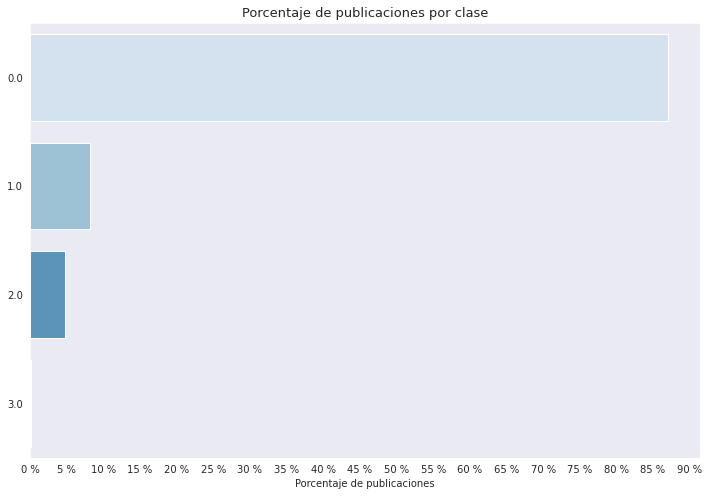

In [ ]:
sns.barplot(data = df_aux, x = "porcentaje", y = "clase", orient = "h", palette= "Blues")

xticks = np.arange(0, 95, 5)
plt.xticks(xticks, [str(int(item)) + " %" for item in xticks])

plt.title(u"Porcentaje de publicaciones por clase", fontsize = 13)
plt.xlabel("Porcentaje de publicaciones", fontsize = 10)
plt.ylabel("")
plt.show()

## Variable: zona_geo

Para armar dicha variable se tendrá en cuenta el porcentaje de aparición de las zonas, agrupando todas las zonas en donde el porcentaje de aparición sea menor al 1%.

In [ ]:
df_total["address__state_name"].value_counts(normalize = True, ascending = False, dropna = False) * 100

Capital Federal        62.419134
Buenos Aires           28.601457
Córdoba                 2.624436
Santa Fe                2.453011
Mendoza                 0.755087
Santa Cruz              0.632640
Entre Ríos              0.428563
Río Negro               0.293872
Chubut                  0.216322
Neuquén                 0.212241
Tucumán                 0.210200
Misiones                0.189792
Salta                   0.185710
San Luis                0.128569
Corrientes              0.118365
Catamarca               0.110202
San Juan                0.089794
Jujuy                   0.067346
La Pampa                0.061223
Chaco                   0.061223
La Rioja                0.057142
Santiago del Estero     0.051019
Formosa                 0.024489
Tierra del Fuego        0.008163
Name: address__state_name, dtype: float64

Por lo tanto, las zonas que quedarían serían: Capital Federal, Buenos Aires, Córdoba y Santa Fe, mientras que las zonas restantes se agruparían bajo la categoría de Otras.

In [ ]:
conditions = [
               df_total['address__state_name'] == 'Capital Federal', 
               df_total['address__state_name'] == 'Buenos Aires',
               df_total['address__state_name'] == 'Córdoba',
               df_total['address__state_name'] == 'Santa Fe'

             ]

outputs = ['Capital Federal', 'Buenos Aires', 'Córdoba', 'Santa Fe']

In [ ]:
df_total['zona_geo'] = pd.Series(np.select(conditions, outputs, 'Otras'))

In [ ]:
df_total["zona_geo"].value_counts(normalize = True, ascending = False, dropna = False) * 100

Capital Federal    62.413012
Buenos Aires       28.601457
Otras               3.901961
Córdoba             2.624436
Santa Fe            2.453011
NaN                 0.006122
Name: zona_geo, dtype: float64

Nuevamente hay valores que caen fuera de las categorías y teniendo en cuenta los porcentajes anteriores de aparición de las distintas zonas con el último obtenido, se puede deducir que esos valores corresponden a la zona de Capital Federal.

In [ ]:
df_total['zona_geo'] = df_total['zona_geo'].fillna('Capital Federal')

In [ ]:
df_total["zona_geo"].value_counts(normalize = True, ascending = False, dropna = False) * 100

Capital Federal    62.419134
Buenos Aires       28.601457
Otras               3.901961
Córdoba             2.624436
Santa Fe            2.453011
Name: zona_geo, dtype: float64

In [ ]:
df_aux = df_total["zona_geo"].value_counts(normalize = True, dropna = False) * 100
df_aux = pd.DataFrame(df_aux).reset_index()
df_aux.rename(columns = {'zona_geo':'porcentaje',
                         'index':'zona'}, inplace = True)

In [ ]:
df_aux

,zona,porcentaje
0,Capital Federal,62.419134
1,Buenos Aires,28.601457
2,Otras,3.901961
3,Córdoba,2.624436
4,Santa Fe,2.453011


In [ ]:
df_aux = df_aux.sort_values(by = 'porcentaje', ascending = False)

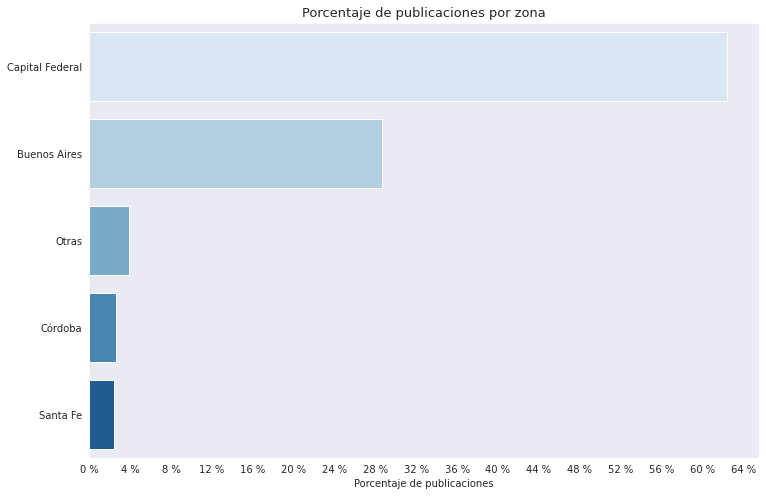

In [ ]:
sns.barplot(data = df_aux, x = "porcentaje", y = "zona", orient = "h", palette= "Blues")

xticks = np.arange(0, 65, 4)
plt.xticks(xticks, [str(int(item)) + " %" for item in xticks])

plt.title(u"Porcentaje de publicaciones por zona", fontsize = 13)
plt.xlabel("Porcentaje de publicaciones", fontsize = 10)
plt.ylabel("")
plt.show()

## Variable: subcategoria

Se generará dicha variable teniendo en cuenta el id de la subcategoría y el nombre correspondiente.

In [ ]:
dicc_categorias_all = {}
for key in categorias_all.keys():
    item = categorias_all[key]
    categoria_id = item["id"]
    categoria_name = item["name"]
    dicc_categorias_all[categoria_id] = categoria_name

In [ ]:
df_total["subcategoria"] = df_total["category_id"].replace(dicc_categorias_all)

In [ ]:
df_total["subcategoria"].value_counts(normalize = True, ascending = False, dropna = False) * 100

Otros                             14.940511
Memorias                           2.048938
Iluminadores                       2.044856
Baterías                           2.042815
Filtros                            2.042815
Cargadores para Cámaras            2.042815
Baterías para Cámaras              2.042815
Flashes para Cámaras               2.042815
Estabilizadores para Cámaras       2.042815
Fundas                             2.042815
Binoculares                        2.042815
Lentes                             2.042815
Correas                            2.042815
Audio y Video                      2.042815
Cámaras Analógicas                 2.042815
Soportes Cámara de Acción          2.040775
Telescopios                        2.040775
Trípodes para Cámaras              2.040775
USB                                2.040775
Microscopios                       2.038734
Álbumes de Fotos                   2.036693
Cámaras Digitales                  2.030571
Filmadoras y Cámaras de Acción  

# Selección de features

In [ ]:
columnas_de_interes = ['buying_mode', 'condition', 'accepts_mercadopago',
                       'shipping__free_shipping', 'shipping__store_pick_up',
                       'tiene_descuento', 'precio_sin_dcto', 'precio_con_dcto',
                       'dcto_porcentual', 'stock', 'cantidad_vendida', 'zona_geo',
                       'subcategoria']

In [ ]:
df_total = df_total[columnas_de_interes]

In [ ]:
df_total.head(2)

,buying_mode,condition,accepts_mercadopago,shipping__free_shipping,shipping__store_pick_up,tiene_descuento,precio_sin_dcto,precio_con_dcto,dcto_porcentual,stock,cantidad_vendida,zona_geo,subcategoria
0,buy_it_now,new,1,0,0,0,699.0,699.0,0.0,4.0,2.0,Buenos Aires,Portarretratos
1,buy_it_now,new,1,1,0,0,15999.0,15999.0,0.0,0.0,2.0,Capital Federal,Portarretratos Digitales


Se aplica one hot encoding a la variables categóricas.

In [ ]:
df_total = pd.get_dummies(df_total)

In [ ]:
df_total = df_total.drop('condition_not_specified', axis = 1)

Se verá si el dataframe tiene valores nulos.

In [ ]:
df_total.isna().sum()

accepts_mercadopago              0
shipping__free_shipping          0
shipping__store_pick_up          0
tiene_descuento                  0
precio_sin_dcto                  3
                                ..
subcategoria_USB                 0
subcategoria_Valijas             0
subcategoria_Viewfinders         0
subcategoria_Zapatas             0
subcategoria_Álbumes de Fotos    0
Length: 112, dtype: int64

Por alguna razón hay 3 valores nulos en la columna de la variable creada precio_sin_dcto. Al ser solo 3 valores, se optará por dropear estas filas.

In [ ]:
df_total = df_total.dropna()

In [ ]:
df_total.isnull().any().sum()

0

# Modelado

Para armar el modelo, el desafío se lo pensó como un problema de clasificación, en donde la variable a predecir, "cantidad_vendida", se divide en 4 clases:


*   Clase 0: 0 ítems vendidos.

*   Clase 1: [1, 50] ítems vendidos.
*   Clase 2: (50, 500] ítems vendidos.

*   Clase 3: (500, inf) ítems vendidos.



Para tener un punto de partida con el que comparar los resultados del modelo que se entrene, se tomará como baseline la distribución porcentual de la variable en cuestión. Se determina la distribución para la variable: "cantidad_vendida".

In [ ]:
(df_total["cantidad_vendida"].value_counts(normalize = True, ascending = False) * 100)

0.0    87.013756
1.0     8.169721
2.0     4.747133
3.0     0.069391
Name: cantidad_vendida, dtype: float64

Por lo tanto, el baseline que se plantea será:


*   Clase 0 = ~87%

*   Clase 1 = ~8.17%
*   Clase 2 = ~4.75%

*   Clase 3 = ~0.07%



Dado que las clases se encuentran muy desbalanceadas y se considera que todas son importantes, la métrica para evaluar el modelo que se tendrá en cuenta será el f1 score.

## Train-test split

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, classification_report, plot_confusion_matrix
from xgboost import XGBClassifier

In [ ]:
X = df_total.drop("cantidad_vendida", axis=1)
y = df_total["cantidad_vendida"].copy()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, stratify = y)

## Modelo: Árbol de Decisión

Se entrenarán árboles de decisión para los siguientes parámetros:

In [ ]:
parameters = {
    'max_depth': [2,3,4,5,6],
    'min_samples_split': [1, 2, 3, 4, 5, 6],
    'min_samples_leaf': [1,2,3,4]
}

In [ ]:
clf = GridSearchCV(DecisionTreeClassifier(), parameters, cv = 3, verbose = 0)
clf.fit(X_train, y_train)
clf.predict(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
60 fits failed out of a total of 360.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py", line 942, in fit
    X_idx_sorted=X_idx_sorted,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py", line 254, in fit
    % self.min_samples_split
ValueError: min_samples_split must be an integer greater than 1 or a float 

array([0., 0., 0., ..., 0., 0., 0.])

Los mejores parámetros elegidos son:

In [ ]:
clf.best_params_

{'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2}

In [ ]:
print(classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.87      1.00      0.93      8527
         1.0       0.00      0.00      0.00       801
         2.0       0.50      0.04      0.08       465
         3.0       0.00      0.00      0.00         7

    accuracy                           0.87      9800
   macro avg       0.34      0.26      0.25      9800
weighted avg       0.78      0.87      0.81      9800



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


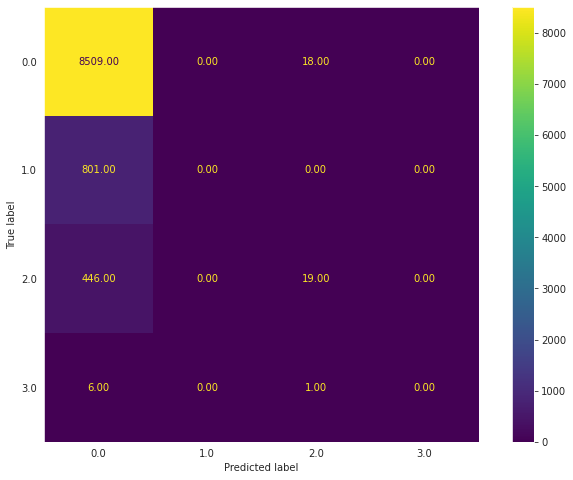

In [ ]:
plot_confusion_matrix(clf, X_test, y_test, values_format = '.2f')
plt.show()

### Feature importances

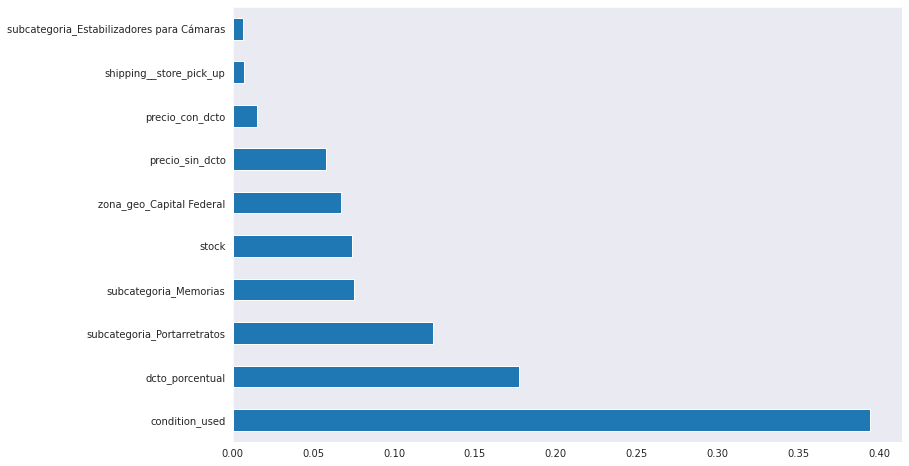

In [ ]:
feat_importances = pd.Series(clf.best_estimator_.feature_importances_, index = X.columns)
feat_importances.nlargest(10).plot(kind = 'barh')
plt.show()

### Conclusión

Como se pueden observar en las métricas f1 score, dadas por el reporte, el modelo con los mejores parámetros seleccionados no está funcionando para nada bien si se lo compara con el baseline ya que, no logra predecir las clases 1 y 3.

## Modelo: Random Forest

Se entrenarán los modelos para los siguientes parámetros:

In [ ]:
parameters = {
    'max_depth': [2,3,4,5,6],
    'min_samples_split': [1, 2, 3, 4, 5, 6],
    'min_samples_leaf': [1,2,3,4],
    'n_estimators': [50, 100, 150, 200, 250]
}

In [ ]:
clf = GridSearchCV(RandomForestClassifier(), parameters, cv = 3, verbose = 0)
clf.fit(X_train, y_train)
clf.predict(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
300 fits failed out of a total of 1800.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
300 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py", line 467, in fit
    for i, t in enumerate(trees)
  File "/usr/local/lib/python3.7/dist-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.7/dist-packages/joblib/

array([0., 0., 0., ..., 0., 0., 0.])

Los mejores parámetros elegidos son:

In [ ]:
clf.best_params_

{'max_depth': 6,
 'min_samples_leaf': 3,
 'min_samples_split': 6,
 'n_estimators': 50}

In [ ]:
print(classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.87      1.00      0.93      8527
         1.0       0.00      0.00      0.00       801
         2.0       0.00      0.00      0.00       465
         3.0       0.00      0.00      0.00         7

    accuracy                           0.87      9800
   macro avg       0.22      0.25      0.23      9800
weighted avg       0.76      0.87      0.81      9800



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


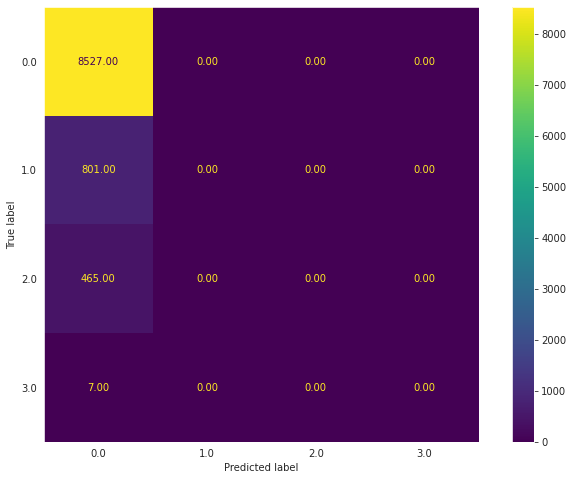

In [ ]:
plot_confusion_matrix(clf, X_test, y_test, values_format = '.2f')
plt.show()

### Feature importances

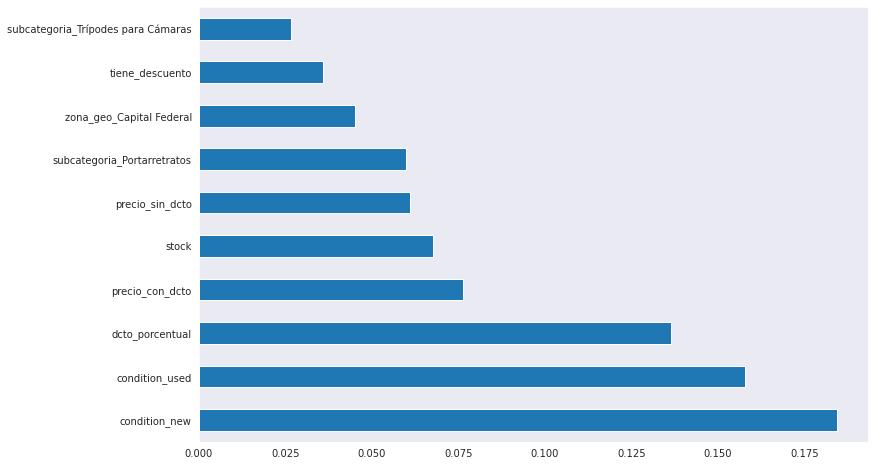

In [ ]:
feat_importances = pd.Series(clf.best_estimator_.feature_importances_, index = X.columns)
feat_importances.nlargest(10).plot(kind = 'barh')
plt.show()

### Conclusión

Como se pueden observar en las métricas f1 score, dadas por el reporte, el modelo con los mejores parámetros seleccionados da peores resultados que el anterior ya que, no predice las clases 1, 2 y 3.

## Modelo: XGBoost

Se entrenarán los modelos para los siguientes parámetros:

In [ ]:
parameters = {
    'max_depth': [2,3,4,5,6],
    'eta': [0.2, 0.3, 0.5, 0.7],
    'n_estimators': [50, 100, 150, 200],
    'objective': ["multi:softmax"]
}

In [ ]:
clf = GridSearchCV(XGBClassifier(), parameters, cv = 3, verbose = 0)
clf.fit(X_train, y_train)
clf.predict(X_test)

array([0., 0., 0., ..., 0., 0., 0.])

Los mejores parámetros elegidos son:

In [ ]:
clf.best_params_

{'eta': 0.2, 'max_depth': 5, 'n_estimators': 150, 'objective': 'multi:softmax'}

In [ ]:
print(classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.87      1.00      0.93      8527
         1.0       0.00      0.00      0.00       801
         2.0       0.65      0.06      0.11       465
         3.0       0.67      0.29      0.40         7

    accuracy                           0.87      9800
   macro avg       0.55      0.34      0.36      9800
weighted avg       0.79      0.87      0.82      9800



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


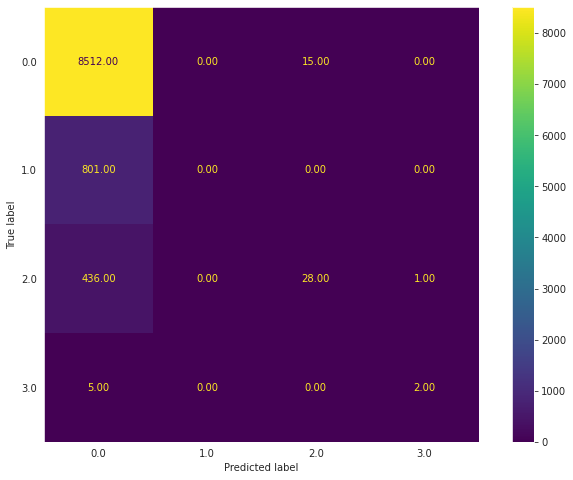

In [ ]:
plot_confusion_matrix(clf, X_test, y_test, values_format = '.2f')
plt.show()

### Feature importances

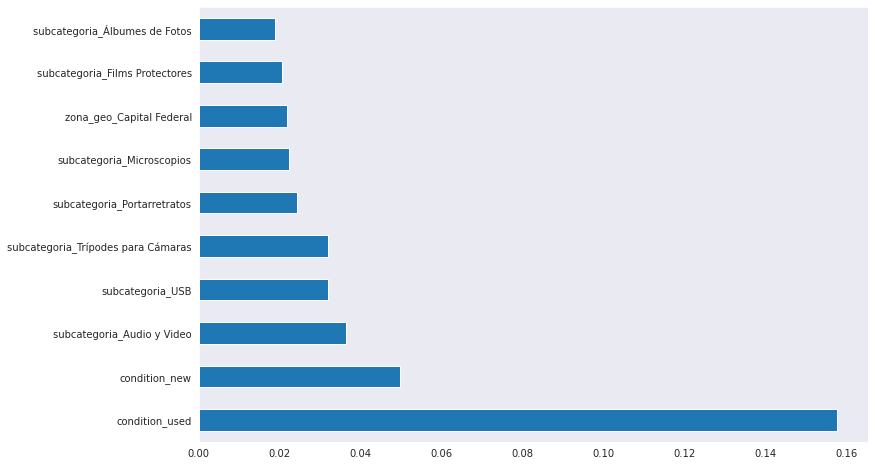

In [ ]:
feat_importances = pd.Series(clf.best_estimator_.feature_importances_, index = X.columns)
feat_importances.nlargest(10).plot(kind = 'barh')
plt.show()

### Conclusión

Como se pueden observar en las métricas f1 score, dadas por el reporte, el modelo con los mejores parámetros seleccionados da resultados un poco mejor que los anteriores, sin embargo, la clase 1 no puede predecirla.

# Puntos a mejorar



*   Dado que el dataset utilizado no es grande ya que, solo se recolectaron aproximadamente 1000 publicaciones por cada subcategoría, se podría trabajar con un dataset conformado por una mayor cantidad de datos.
*   En los modelos que se entrenaron, se seleccionaron pocos hiperparámetros para probar, por lo tanto, no se descarta la idea de reentrenar estos mismos modelos con otros parámetros para observar si hay alguna mejora o no.
*   Entrenar otros modelos distintos ya que, por una cuestión de tiempo solo se utilizaron Árboles de Decisión y Random Forest.




In [18]:
datos = {
    'Modelo': ['DecisionTree', 'DecisionTree', 'DecisionTree','DecisionTree', 'RandomForest', 'RandomForest', 'RandomForest', 'RandomForest', 'XGBoost', 'XGBoost', 'XGBoost', 'XGBoost'],
    'Clase': [0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3],
    'F1Score': [0.93, 0.00, 0.08, 0.00, 0.93, 0.00, 0.00, 0.00, 0.93, 0.00, 0.11, 0.40]
}

In [19]:
df_aux = pd.DataFrame(datos)

In [20]:
df_aux

,Modelo,Clase,F1Score
0,DecisionTree,0,0.93
1,DecisionTree,1,0.00
2,DecisionTree,2,0.08
3,DecisionTree,3,0.00
4,RandomForest,0,0.93
5,RandomForest,1,0.00
6,RandomForest,2,0.00
7,RandomForest,3,0.00
8,XGBoost,0,0.93
9,XGBoost,1,0.00


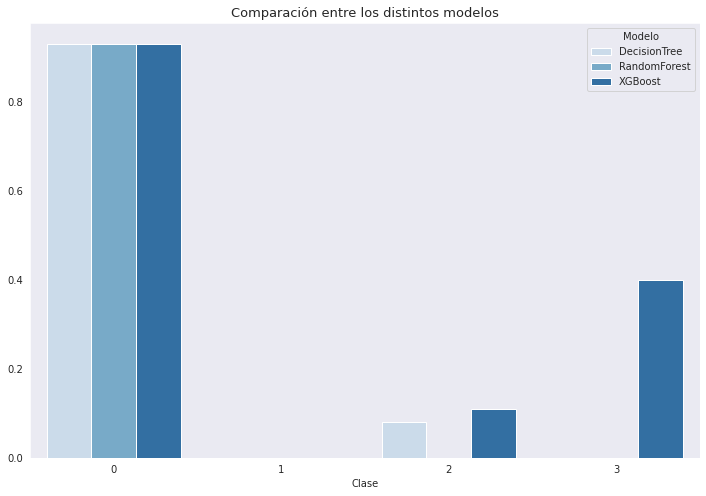

In [22]:
sns.barplot(x = 'Clase',
            y = 'F1Score',
            hue = 'Modelo',
            data = df_aux,
            palette = 'Blues')
plt.title(u"Comparación entre los distintos modelos", fontsize = 13)
plt.xlabel("Clase", fontsize = 10)
plt.ylabel("")
plt.show()